# Mod 5 Final Project

Jeremy Owens

Import necessary libraries

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, mean_squared_error, f1_score

%matplotlib inline

## Data Cleaning / EDA

We begin our process by reading in the 2016 School Explorer Dataset and eliminating a variety of columns that are not useful to our analysis

In [25]:
schools_df = pd.read_csv('2016 School Explorer.csv')
cols_to_drop = ['Adjusted Grade', 
                'New?', 
                'Other Location Code in LCGMS',
                'School Name',
                'District',
                'SED Code', 
                'Latitude', 
                'Longitude',
                'Address (Full)',
                'City',
                'Zip',
                'Grades',
                'Rigorous Instruction Rating',
                'Collaborative Teachers Rating',
                'Supportive Environment Rating',
                'Effective School Leadership Rating',
                'Strong Family-Community Ties Rating',
                'Trust Rating',
                'School Income Estimate',
                'Average ELA Proficiency',
                'Community School?',
                'Grade 3 ELA - All Students Tested',
                'Grade 3 ELA 4s - All Students',
                'Grade 3 ELA 4s - American Indian or Alaska Native',
                'Grade 3 ELA 4s - Black or African American',
                'Grade 3 ELA 4s - Hispanic or Latino',
                'Grade 3 ELA 4s - Asian or Pacific Islander',
                'Grade 3 ELA 4s - White',
                'Grade 3 ELA 4s - Multiracial',
                'Grade 3 ELA 4s - Limited English Proficient',
                'Grade 3 ELA 4s - Economically Disadvantaged',
                'Grade 3 Math - All Students tested',
                'Grade 3 Math 4s - All Students',
                'Grade 3 Math 4s - American Indian or Alaska Native',
                'Grade 3 Math 4s - Black or African American',
                'Grade 3 Math 4s - Hispanic or Latino',
                'Grade 3 Math 4s - Asian or Pacific Islander',
                'Grade 3 Math 4s - White',
                'Grade 3 Math 4s - Multiracial',
                'Grade 3 Math 4s - Limited English Proficient',
                'Grade 3 Math 4s - Economically Disadvantaged',
                'Grade 4 ELA - All Students Tested',
                'Grade 4 ELA 4s - All Students',
                'Grade 4 ELA 4s - American Indian or Alaska Native',
                'Grade 4 ELA 4s - Black or African American',
                'Grade 4 ELA 4s - Hispanic or Latino',
                'Grade 4 ELA 4s - Asian or Pacific Islander',
                'Grade 4 ELA 4s - White',
                'Grade 4 ELA 4s - Multiracial',
                'Grade 4 ELA 4s - Limited English Proficient',
                'Grade 4 ELA 4s - Economically Disadvantaged',
                'Grade 4 Math - All Students Tested',
                'Grade 4 Math 4s - All Students',
                'Grade 4 Math 4s - American Indian or Alaska Native',
                'Grade 4 Math 4s - Black or African American',
                'Grade 4 Math 4s - Hispanic or Latino',
                'Grade 4 Math 4s - Asian or Pacific Islander',
                'Grade 4 Math 4s - White',
                'Grade 4 Math 4s - Multiracial',
                'Grade 4 Math 4s - Limited English Proficient',
                'Grade 4 Math 4s - Economically Disadvantaged',
                'Grade 5 ELA - All Students Tested',
                'Grade 5 ELA 4s - All Students',
                'Grade 5 ELA 4s - American Indian or Alaska Native',
                'Grade 5 ELA 4s - Black or African American',
                'Grade 5 ELA 4s - Hispanic or Latino',
                'Grade 5 ELA 4s - Asian or Pacific Islander',
                'Grade 5 ELA 4s - White',
                'Grade 5 ELA 4s - Multiracial',
                'Grade 5 ELA 4s - Limited English Proficient',
                'Grade 5 ELA 4s - Economically Disadvantaged',
                'Grade 5 Math - All Students Tested',
                'Grade 5 Math 4s - All Students',
                'Grade 5 Math 4s - American Indian or Alaska Native',
                'Grade 5 Math 4s - Black or African American',
                'Grade 5 Math 4s - Hispanic or Latino',
                'Grade 5 Math 4s - Asian or Pacific Islander',
                'Grade 5 Math 4s - White',
                'Grade 5 Math 4s - Multiracial',
                'Grade 5 Math 4s - Limited English Proficient',
                'Grade 5 Math 4s - Economically Disadvantaged',
                'Grade 6 ELA - All Students Tested',
                'Grade 6 ELA 4s - All Students',
                'Grade 6 ELA 4s - American Indian or Alaska Native',
                'Grade 6 ELA 4s - Black or African American',
                'Grade 6 ELA 4s - Hispanic or Latino',
                'Grade 6 ELA 4s - Asian or Pacific Islander',
                'Grade 6 ELA 4s - White',
                'Grade 6 ELA 4s - Multiracial',
                'Grade 6 ELA 4s - Limited English Proficient',
                'Grade 6 ELA 4s - Economically Disadvantaged',
                'Grade 6 Math - All Students Tested',
                'Grade 6 Math 4s - All Students',
                'Grade 6 Math 4s - American Indian or Alaska Native',
                'Grade 6 Math 4s - Black or African American',
                'Grade 6 Math 4s - Hispanic or Latino',
                'Grade 6 Math 4s - Asian or Pacific Islander',
                'Grade 6 Math 4s - White',
                'Grade 6 Math 4s - Multiracial',
                'Grade 6 Math 4s - Limited English Proficient',
                'Grade 6 Math 4s - Economically Disadvantaged',
                'Grade 7 ELA - All Students Tested',
                'Grade 7 ELA 4s - All Students',
                'Grade 7 ELA 4s - American Indian or Alaska Native',
                'Grade 7 ELA 4s - Black or African American',
                'Grade 7 ELA 4s - Hispanic or Latino',
                'Grade 7 ELA 4s - Asian or Pacific Islander',
                'Grade 7 ELA 4s - White',
                'Grade 7 ELA 4s - Multiracial',
                'Grade 7 ELA 4s - Limited English Proficient',
                'Grade 7 ELA 4s - Economically Disadvantaged',
                'Grade 7 Math - All Students Tested',
                'Grade 7 Math 4s - All Students',
                'Grade 7 Math 4s - American Indian or Alaska Native',
                'Grade 7 Math 4s - Black or African American',
                'Grade 7 Math 4s - Hispanic or Latino',
                'Grade 7 Math 4s - Asian or Pacific Islander',
                'Grade 7 Math 4s - White',
                'Grade 7 Math 4s - Multiracial',
                'Grade 7 Math 4s - Limited English Proficient',
                'Grade 7 Math 4s - Economically Disadvantaged',
                'Grade 8 ELA - All Students Tested',
                'Grade 8 ELA 4s - All Students',
                'Grade 8 ELA 4s - American Indian or Alaska Native',
                'Grade 8 ELA 4s - Black or African American',
                'Grade 8 ELA 4s - Hispanic or Latino',
                'Grade 8 ELA 4s - Asian or Pacific Islander',
                'Grade 8 ELA 4s - White',
                'Grade 8 ELA 4s - Multiracial',
                'Grade 8 ELA 4s - Limited English Proficient',
                'Grade 8 ELA 4s - Economically Disadvantaged',
                'Grade 8 Math - All Students Tested',
                'Grade 8 Math 4s - All Students',
                'Grade 8 Math 4s - American Indian or Alaska Native',
                'Grade 8 Math 4s - Black or African American',
                'Grade 8 Math 4s - Hispanic or Latino',
                'Grade 8 Math 4s - Asian or Pacific Islander',
                'Grade 8 Math 4s - White',
                'Grade 8 Math 4s - Multiracial',
                'Grade 8 Math 4s - Limited English Proficient',
                'Grade 8 Math 4s - Economically Disadvantaged'
                ]
schools_df.drop(cols_to_drop, axis=1, inplace=True)

In [26]:
def acheivement_score(rating):
    '''
    Takes the rating passed to it and returns an integer
    value representing how school meets target goals
    '''
    if rating == 'Exceeding Target':
        return 4
    if rating == 'Meeting Target':
        return 3
    if rating == 'Approaching Target':
        return 2
    if rating == 'Not Meeting Target':
        return 1
    else:
        return None

In [27]:
def percent_cols_to_float(df):
    '''
    For any dataframe passed in, returns a new dataframe where
    values are floats between 0 and 1 representing the respective
    rate or percent in that column
    '''
    for col in df.columns:
        if 'Rate' in col or 'Percent' in col or '%' in col:
            df[col] = df[col].apply(lambda x: float(x.replace('%',''))*.01)
    return df

In [28]:
def make_grades_int(grade):
    '''
    Takes a grade and returns an integer representative of that 
    grade in the school system
    '''
    if grade == 'PK':
        return -1
    elif grade == '0K':
        return 0
    else:
        return int(grade)

In [29]:
schools_df['Student Achievement Rating'] = schools_df['Student Achievement Rating'].apply(lambda x: acheivement_score(x))
schools_df['Student Achievement Rating'].fillna(schools_df['Student Achievement Rating'].median(), inplace=True)

In [30]:
schools_df.dropna(inplace=True)

In [31]:
schools_df = percent_cols_to_float(schools_df)

In [32]:
races_to_drop = ['Percent ELL',
                 'Percent Asian',
                 'Percent Black',
                 'Percent Hispanic',
                 'Percent Black / Hispanic',
                 'Percent White']
race_df = schools_df[['Location Code'] + races_to_drop].set_index('Location Code')
schools_df = schools_df.drop(races_to_drop, axis=1).set_index('Location Code')

In [33]:
schools_df['Grade Low'] = schools_df['Grade Low'].apply(lambda x: make_grades_int(x))
schools_df['Grade High'] = schools_df['Grade High'].apply(lambda x: make_grades_int(x))
schools_df['Grade_range'] = schools_df['Grade High'] - schools_df['Grade Low']
schools_df.drop(['Grade Low', 'Grade High'], axis=1, inplace=True)

### Incorportation of Additional Data

Importing the Pupil to Teacher dataset for joining to main dataset

In [34]:
pupil_teacher_ratio_df = pd.read_csv('2015_-_2016_Final_Class_Size_Report_Pupil-to-Teacher_Ratio__PTR_.csv')
pupil_teacher_ratio_df = pupil_teacher_ratio_df.drop('School Name', axis=1).set_index('DBN')

In [35]:
final_df = schools_df.join(pupil_teacher_ratio_df)

In [36]:
display(final_df.info())
display(final_df.head())
display(race_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 1217 entries, 01M015 to 84X730
Data columns (total 13 columns):
Economic Need Index                       1217 non-null float64
Student Attendance Rate                   1217 non-null float64
Percent of Students Chronically Absent    1217 non-null float64
Rigorous Instruction %                    1217 non-null float64
Collaborative Teachers %                  1217 non-null float64
Supportive Environment %                  1217 non-null float64
Effective School Leadership %             1217 non-null float64
Strong Family-Community Ties %            1217 non-null float64
Trust %                                   1217 non-null float64
Student Achievement Rating                1217 non-null float64
Average Math Proficiency                  1217 non-null float64
Grade_range                               1217 non-null int64
School Pupil-Teacher Ratio                1083 non-null float64
dtypes: float64(12), int64(1)
memory usage: 173.1+ KB


None

,Economic Need Index,Student Attendance Rate,Percent of Students Chronically Absent,Rigorous Instruction %,Collaborative Teachers %,Supportive Environment %,Effective School Leadership %,Strong Family-Community Ties %,Trust %,Student Achievement Rating,Average Math Proficiency,Grade_range,School Pupil-Teacher Ratio
Location Code,,,,,,,,,,,,,
01M015,0.919,0.94,0.18,0.89,0.94,0.86,0.91,0.85,0.94,2.0,2.17,6,9.2
01M019,0.641,0.92,0.30,0.96,0.96,0.97,0.90,0.86,0.94,4.0,2.98,6,7.0
01M020,0.744,0.94,0.20,0.87,0.77,0.82,0.61,0.80,0.79,2.0,2.54,6,13.3
01M034,0.860,0.92,0.28,0.85,0.78,0.82,0.73,0.89,0.88,4.0,2.47,9,10.9
01M063,0.730,0.93,0.23,0.90,0.88,0.87,0.81,0.89,0.93,3.0,2.54,6,10.6


,Percent ELL,Percent Asian,Percent Black,Percent Hispanic,Percent Black / Hispanic,Percent White
Location Code,,,,,,
01M015,0.09,0.05,0.32,0.60,0.92,0.01
01M019,0.05,0.10,0.20,0.63,0.83,0.06
01M020,0.15,0.35,0.08,0.49,0.57,0.04
01M034,0.07,0.05,0.29,0.63,0.92,0.04
01M063,0.03,0.04,0.20,0.65,0.84,0.10


## Model Formation - No Student-Teacher Ratio

In [39]:
no_ratio_df = final_df.drop('School Pupil-Teacher Ratio', axis=1)

In [61]:
upper_quartile = no_ratio_df['Average Math Proficiency'].quantile(.75)
y = no_ratio_df['Average Math Proficiency'].apply(lambda x: 1 if x >= upper_quartile else 0)
X = no_ratio_df.drop('Average Math Proficiency', axis=1)
features = X.columns

In [62]:
X = StandardScaler().fit_transform(X.astype({'Grade_range': 'float64'}))

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3)

### KNN

In [89]:
k_range = range(1, 40)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = f1_score(y_test, y_pred, average='weighted')
    k_scores.append( score)
best_k_score = {'k_score': k_scores.index(max(k_scores))+1, 'f1_score': max(k_scores)}
print(best_k_score)

{'k_score': 11, 'f1_score': 0.8856874649461892}


### CART

In [96]:
depth_range = range(1,40)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth)
    depth_score = cross_val_score(ctree, X, y, cv=3)
    val.append(depth_score.mean())
best_dt_score = {'depth_score': val.index(max(val))+1, 'cross_val_score': max(val)}
print(best_dt_score)

{'depth_score': 5, 'cross_val_score': 0.859407245231}


### SVM

In [97]:
svm_types = ['linear', 'poly', 'rbf', 'sigmoid']

In [102]:
warnings.filterwarnings('ignore')
svm_scores = []
for svm in svm_types:
    svclassifier = SVC(kernel=svm)  
    svclassifier.fit(X_train, y_train) 
    y_pred = svclassifier.predict(X_test)
    svm_scores.append(f1_score(y_test, y_pred, average='weighted'))
best_svm_score = {'svm_type': svm_types[svm_scores.index(max(svm_scores))], 'f1_score': max(svm_scores)}
print(best_svm_score)

{'svm_type': 'linear', 'f1_score': 0.8892617092214444}


### XG Boost

In [105]:
param_grid = {
    "learning_rate": [0.1, .001],
    'max_depth': [6, 10],
    'min_child_weight': [10],
    'subsample': [0.7],
    'n_estimators': [5, 30, 100, 250]
}

In [106]:
# clf = xgb.XGBClassifier()
# clf.fit(X_train, y_train)
# training_preds = clf.predict(X_train)
# val_preds = clf.predict(X_test)
# training_accuracy = accuracy_score(y_train, training_preds)
# val_accuracy = accuracy_score(y_test, val_preds)

# print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
# print("Validation accuracy: {:.4}%".format(val_accuracy * 100))

In [1]:
clf = xgb.XGBClassifier()
grid_clf = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print("Grid Search found the following optimal parameters: ")
for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
val_preds = grid_clf.predict(X_test)
training_f1 = f1_score(y_train, training_preds)
val_f1 = f1_score(y_test, val_preds)

print("")
print("Training F1: {:.4}%".format(training_f1 * 100))
print("Validation F1: {:.4}%".format(val_f1 * 100))

NameError: name 'xgb' is not defined

# PCA Trial

In [63]:
pca = PCA()
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data=principalComponents)

In [64]:
pca.explained_variance_ratio_

array([0.38836648, 0.18129439, 0.11336637, 0.08783533, 0.06420309,
       0.05646266, 0.04686128, 0.03139097, 0.01338449, 0.00989564,
       0.00693931])

In [65]:
pca.explained_variance_

array([4.27554443, 1.99587827, 1.24805558, 0.96698316, 0.70681472,
       0.62160006, 0.51589798, 0.34558465, 0.14735046, 0.10894159,
       0.07639515])

In [66]:
principalDf.head()

,0,1,2,3,4,5,6,7,8,9,10
0,-0.526660,0.806219,-0.473136,-1.876378,-0.309761,0.605951,-0.212830,-0.226192,0.552265,0.241854,0.002682
1,-2.250150,0.521489,0.105779,1.119872,-0.776556,-0.229806,0.102195,0.185383,-0.677910,0.294154,-0.057105
2,3.227074,-0.419903,1.082601,-0.653642,0.402790,-0.859926,-0.335302,-0.320959,0.364672,0.076237,0.320581
3,1.328937,0.270621,1.687033,0.885261,-1.487946,0.838126,1.111083,-0.962218,-0.095578,-0.584505,-0.275167
4,-0.351979,0.369809,0.418588,-0.254193,-0.166754,0.148863,0.545075,-0.599504,0.039130,-0.387677,0.044674


In [67]:
eig_values = pca.explained_variance_
eig_vectors = pca.components_
print(eig_values)
print(eig_vectors)

[4.27554443 1.99587827 1.24805558 0.96698316 0.70681472 0.62160006
 0.51589798 0.34558465 0.14735046 0.10894159 0.07639515]
[[ 0.1844014  -0.04269624  0.15689493 -0.35123821 -0.4390081  -0.3798192
  -0.40724185 -0.30915203 -0.43135029 -0.17267631 -0.04355503]
 [ 0.40358891 -0.56409818  0.63099426  0.08268854  0.10848671  0.03675596
   0.07963753  0.17943609  0.12282964 -0.2104772   0.05357706]
 [-0.17339868 -0.04980526 -0.03735519  0.12772054 -0.20647612  0.19163458
  -0.30913942  0.38046864 -0.18794851 -0.04002884  0.77015432]
 [-0.29231998 -0.46474021  0.12422576  0.0924443  -0.09297433  0.04857723
  -0.10812059 -0.15205653 -0.14470324  0.77244714 -0.10563495]
 [-0.7171641  -0.32726856  0.00892459 -0.10264916 -0.03454146 -0.01212517
  -0.00895246  0.20013886 -0.0546341  -0.47559338 -0.31193693]
 [-0.14090267 -0.16877221 -0.06406436 -0.5574853   0.1759185  -0.46184481
   0.3893538  -0.04160726  0.18735352  0.11357732  0.43725466]
 [ 0.17893144  0.08776063 -0.02052436 -0.57494214 -0.16

In [68]:
structure_loading_1 = eig_vectors[0]* np.sqrt(eig_values[0])
str_loading_1 = pd.Series(structure_loading_1, index=features)
str_loading_1

Economic Need Index                       0.381294
Student Attendance Rate                  -0.088285
Percent of Students Chronically Absent    0.324418
Rigorous Instruction %                   -0.726269
Collaborative Teachers %                 -0.907754
Supportive Environment %                 -0.785367
Effective School Leadership %            -0.842070
Strong Family-Community Ties %           -0.639246
Trust %                                  -0.891920
Student Achievement Rating               -0.357050
Grade_range                              -0.090060
dtype: float64

In [69]:
str_loading_1.sort_values(ascending=False)

Economic Need Index                       0.381294
Percent of Students Chronically Absent    0.324418
Student Attendance Rate                  -0.088285
Grade_range                              -0.090060
Student Achievement Rating               -0.357050
Strong Family-Community Ties %           -0.639246
Rigorous Instruction %                   -0.726269
Supportive Environment %                 -0.785367
Effective School Leadership %            -0.842070
Trust %                                  -0.891920
Collaborative Teachers %                 -0.907754
dtype: float64

Text(0, 0.5, 'proportion of explained variance')

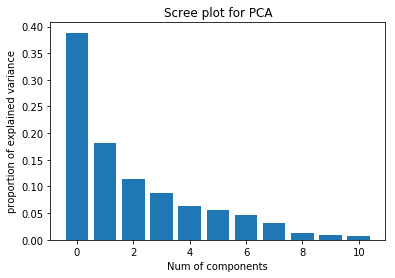

In [70]:
index = np.arange(len(features))
plt.bar(index, pca.explained_variance_ratio_)
plt.title('Scree plot for PCA')
plt.xlabel('Num of components')
plt.ylabel('proportion of explained variance')

Text(0, 0.5, 'explained variance ratio')

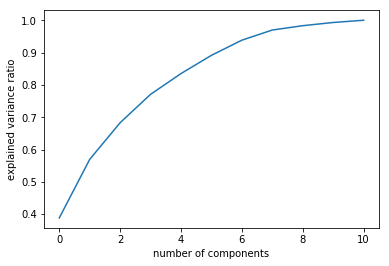

In [71]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('explained variance ratio')

## Model Formation - With Student-Teacher Ratio

In [38]:
ratio_df = final_df.dropna()

# Working Zone

In [ ]:
shsat_df = pd.read_csv('D5 SHSAT Registrations and Testers.csv')
print(len(shsat_df))
shsat_df.head()

In [ ]:
shsat_df['Enroll_register'] = round(shsat_df['Number of students who registered for the SHSAT'] / shsat_df['Enrollment on 10/31'], 4)
shsat_df['Enroll_took'] = round(shsat_df['Number of students who took the SHSAT'] / shsat_df['Enrollment on 10/31'], 4)
shsat_df


In [ ]:
new_df = pd.concat([schools_df, pd.get_dummies(schools_df)], axis=1)
new_df.head()

In [10]:
schools_df['Community School?'] = schools_df['Community School?'].apply(lambda x: 1 if x=='Yes' else 0)